In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import KFold 

import fragility_index as fi

import warnings
warnings.filterwarnings("ignore")

In [2]:
def performance(ranking_error):        
    v_prob = np.mean(ranking_error>=0.00001)
    v_mean = np.mean(ranking_error)
    v_std = np.std(ranking_error)
    v_var95 = np.quantile(ranking_error, 0.95)
    v_var99 = np.quantile(ranking_error, 0.99)
    v_cvar95 = np.mean(ranking_error[ranking_error>=v_var95])
    v_cvar99 = np.mean(ranking_error[ranking_error>=v_var99])
    
        
    return v_var95,v_var99,v_cvar95,v_cvar99

In [3]:

# 5-fold cross-validation



# data_name_list = ['BreastCancerCoimbra','LiverDisorders', 'LiverPatient', 'GermanCredit',\
                #   'BreastCancerPrognostic','Australian','Diabetes','Ionosphere','Sonar','SpamBase']

data_name_list = ['BreastCancerCoimbra','LiverDisorders', 'LiverPatient', 'GermanCredit',\
                  'BreastCancerPrognostic','Australian','Diabetes','Ionosphere','Sonar']

# data_name_list = ['BreastCancerPrognostic'] 

lr = LogisticRegression()
gnb = GaussianNB()
svc = LinearSVC(C=1.0,max_iter=50000)
rfc = RandomForestClassifier()
neigh = KNeighborsClassifier(n_neighbors=10)
mlp = MLPClassifier(alpha=1, max_iter=1000)
# quad = QuadraticDiscriminantAnalysis()
ada = AdaBoostClassifier()

k = 5
N=20


model_name_list = np.array(
    [[lr, 'Logistic'],
    [gnb, 'Naive Bayes'],
    [svc, 'Support Vector Classification'],
    [rfc, 'Random Forest'],
    [mlp, 'Neural Net'],
#     [quad, 'Quadratic Discriminant Analysis'],
    [neigh, 'K-Nearest']])

# model_name_list=np.array([[neigh, 'K-Nearest']])

criteria_list = ['AUC','bAUC','FI']

result_perf = pd.DataFrame(columns=['data','j','crit','model','AUC','bAUC','FI','accuracy','F-Measure','MCC'])

for data_name in data_name_list:
    print(data_name)
    x,y = fi.Data_load(data_name)      # import data
    

    for n in range(N):
        np.random.seed(n)
        X_sample, X_test, y_sample, y_test = train_test_split(x, y, test_size=0.2) 
        scaler = StandardScaler()
        X_sample = scaler.fit_transform(X_sample)
        X_test = scaler.transform(X_test)
            
        kf = KFold(n_splits=k, random_state=None)
        result_k_fold = pd.DataFrame(columns=['i','crit','model','value'])
        for index,(train_index , validate_index) in enumerate(kf.split(X_sample)):
            X_train , X_validate = X_sample[train_index,:],X_sample[validate_index,:]
            y_train , y_validate = y_sample[train_index] , y_sample[validate_index]
            
            
            for clf, name in model_name_list:
                clf.fit(X_train, y_train)
                if hasattr(clf, "predict_proba"):
                    prob_pos = clf.predict_proba(X_validate)[:, 1]  
                else:  # use decision function
                    func = clf.decision_function(X_validate)
                    prob_pos = 1/(1 + np.exp(-func))

                y_pred = clf.predict(X_train)
                acc = accuracy_score(y_train, y_pred)    
                AUC = roc_auc_score(y_validate, prob_pos)
                FI, error = fi.FI_calculation(prob_pos,y_validate)
                bAUC= fi.bAUC_calculation(error)
#                 print(AUC,FI,bAUC,name,index)



                res1 = pd.DataFrame({'i':[index],'model':[name],'crit':['AUC'],'value':[AUC]})
                res2 = pd.DataFrame({'i':[index],'model':[name],'crit':['bAUC'],'value':[bAUC]})
                res3 = pd.DataFrame({'i':[index],'model':[name],'crit':['FI'],'value':[FI]})
                result_k_fold = pd.concat([result_k_fold,res1,res2,res3])
        k_fold = result_k_fold.groupby(['crit','model']).mean().reset_index() 
        
        for crit in criteria_list:
            perf = k_fold[k_fold.crit==crit].reset_index()
            if (crit == 'AUC') | (crit == 'bAUC') :
                model = perf.model[perf.value.argmax()]
            elif crit == 'FI':
                model = perf.model[perf.value.argmin()]

            clf = model_name_list[model_name_list[:,1]==model][0,0]  
            clf.fit(X_sample, y_sample)
            if hasattr(clf, "predict_proba"):
                prob_pos = clf.predict_proba(X_test)[:, 1]
            else:  # use decision function  
                func = clf.decision_function(X_test)
                prob_pos = 1/(1 + np.exp(-func))

            AUC = roc_auc_score(y_test, prob_pos)
            FI, error = fi.FI_calculation(prob_pos,y_test)
            bAUC = fi.bAUC_calculation(error)
#             print(AUC,FI,bAUC)


            y_pred = clf.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            mcc = matthews_corrcoef(y_test, y_pred)
            
            v_var95,v_var99,v_cvar95,v_cvar99 = performance(error)

            res = pd.DataFrame({'data':[data_name],'j':[n],'crit':[crit],'model':[model],'AUC':[AUC],'bAUC':[bAUC],
                                'FI':[FI],'accuracy':[acc],'F-Measure':[f1],'MCC':[mcc], "VaR%95": [v_var95],
                            "CVaR%95": [v_cvar95],
                            "VaR%99": [v_var99],
                            "CVaR%99": [v_cvar99]})

            result_perf = pd.concat([result_perf,res])
# result = result_perf.groupby(['data','crit']).agg(['mean','std']).reset_index()

# avg_df= result_perf.groupby(['data','crit']).mean().reset_index().rename(columns={'AUC':"AUC_avg",
#                                                                                   'bAUC':"bAUC_avg",
#                                                                                   'FI':"FI_avg",
#                                                                                  "accuracy":"accuracy_avg",
#                                                                                   "F-Measure":"F-Measure_avg",
#                                                                                   "MCC":"MCC_avg"})
# df = pd.merge(result_perf,avg_df,on=['data','crit'])
# df['accuracy_bias'] = np.abs(df['accuracy']-df['accuracy_avg'])
# df['F-Measure_bias'] = np.abs(df['F-Measure']-df['F-Measure_avg'])
# df['MCC_bias'] = np.abs(df['MCC']-df['MCC_avg'])
# bias_df = df.groupby(['data','crit']).max().reset_index()
# df = pd.merge(avg_df,bias_df[['data','crit','accuracy_bias','F-Measure_bias','MCC_bias']],on=['data','crit'])
# columns=['data','crit','accuracy_avg','accuracy_bias','F-Measure_avg','F-Measure_bias','MCC_avg','MCC_bias']
# df[columns]

BreastCancerCoimbra
LiverDisorders
LiverPatient
GermanCredit
BreastCancerPrognostic
Australian
Diabetes
Ionosphere
Sonar


In [4]:
result = result_perf.groupby(['data','crit']).agg({'accuracy':['mean','std'],
                                                   'F-Measure':['mean','std'],'MCC':['mean','std'],
                                                  'AUC':['mean','std'],'bAUC':['mean','std'],
                                                   'FI':['mean','std'],'CVaR%95':['mean','std'],
                                                   'CVaR%99':['mean','std']})
result.columns = ["_".join(x) for x in result.columns.ravel()]

In [5]:
format='%.2f +/- %.2f'
result['AUC']= result.apply(lambda x:format%(x['AUC_mean'],x['AUC_std']),axis=1)
result['bAUC']= result.apply(lambda x:format%(x['bAUC_mean'],x['bAUC_std']),axis=1)
result['FI']= result.apply(lambda x:format%(x['FI_mean'],x['FI_std']),axis=1)

result['accuracy']= result.apply(lambda x:format%(x['accuracy_mean'],x['accuracy_std']),axis=1)
result['F-Measure']= result.apply(lambda x:format%(x['F-Measure_mean'],x['F-Measure_std']),axis=1)
result['MCC']= result.apply(lambda x:format%(x['MCC_mean'],x['MCC_std']),axis=1)

result['CVaR%95']= result.apply(lambda x:format%(x['CVaR%95_mean'],x['CVaR%95_std']),axis=1)
result['CVaR%99']= result.apply(lambda x:format%(x['CVaR%99_mean'],x['CVaR%99_std']),axis=1)

result.drop(columns=['accuracy_mean','accuracy_std','F-Measure_mean','F-Measure_std','MCC_mean',
                     'MCC_std','AUC_mean','AUC_std','bAUC_mean','bAUC_std','FI_mean','FI_std','CVaR%95_mean',
                    'CVaR%99_mean','CVaR%95_std','CVaR%99_std']).reset_index()

,data,crit,AUC,bAUC,FI,accuracy,F-Measure,MCC,CVaR%95,CVaR%99
0,Australian,AUC,0.93 +/- 0.02,0.82 +/- 0.05,0.15 +/- 0.04,0.86 +/- 0.03,0.85 +/- 0.03,0.72 +/- 0.05,0.26 +/- 0.11,0.57 +/- 0.16
1,Australian,FI,0.93 +/- 0.02,0.82 +/- 0.06,0.08 +/- 0.02,0.86 +/- 0.03,0.85 +/- 0.03,0.72 +/- 0.05,0.14 +/- 0.06,0.31 +/- 0.07
2,Australian,bAUC,0.93 +/- 0.02,0.83 +/- 0.05,0.13 +/- 0.04,0.86 +/- 0.03,0.85 +/- 0.03,0.73 +/- 0.06,0.23 +/- 0.10,0.50 +/- 0.16
3,BreastCancerCoimbra,AUC,0.83 +/- 0.07,0.59 +/- 0.16,0.23 +/- 0.12,0.75 +/- 0.08,0.72 +/- 0.11,0.49 +/- 0.17,0.44 +/- 0.20,0.62 +/- 0.23
4,BreastCancerCoimbra,FI,0.79 +/- 0.09,0.51 +/- 0.19,0.17 +/- 0.11,0.71 +/- 0.12,0.68 +/- 0.14,0.45 +/- 0.22,0.30 +/- 0.14,0.41 +/- 0.18
5,BreastCancerCoimbra,bAUC,0.83 +/- 0.07,0.61 +/- 0.15,0.21 +/- 0.12,0.74 +/- 0.10,0.71 +/- 0.12,0.49 +/- 0.19,0.43 +/- 0.19,0.59 +/- 0.24
6,BreastCancerPrognostic,AUC,0.78 +/- 0.10,0.49 +/- 0.23,0.21 +/- 0.15,0.78 +/- 0.07,0.86 +/- 0.05,0.38 +/- 0.21,0.35 +/- 0.19,0.48 +/- 0.23
7,BreastCancerPrognostic,FI,0.78 +/- 0.09,0.49 +/- 0.19,0.20 +/- 0.12,0.79 +/- 0.07,0.86 +/- 0.05,0.38 +/- 0.19,0.34 +/- 0.14,0.47 +/- 0.18
8,BreastCancerPrognostic,bAUC,0.79 +/- 0.10,0.51 +/- 0.23,0.20 +/- 0.14,0.79 +/- 0.07,0.86 +/- 0.05,0.39 +/- 0.21,0.32 +/- 0.16,0.45 +/- 0.20
9,Diabetes,AUC,0.84 +/- 0.03,0.59 +/- 0.06,0.15 +/- 0.05,0.78 +/- 0.03,0.63 +/- 0.05,0.49 +/- 0.07,0.32 +/- 0.11,0.49 +/- 0.15


In [6]:
result_perf[result_perf.data=='BreastCancerPrognostic']

,data,j,crit,model,AUC,bAUC,FI,accuracy,F-Measure,MCC,VaR%95,CVaR%95,VaR%99,CVaR%99
0,BreastCancerPrognostic,0,AUC,Support Vector Classification,0.774295,0.495298,0.122070,0.725,0.819672,0.251952,0.190123,0.260100,0.295422,0.331657
0,BreastCancerPrognostic,0,bAUC,Support Vector Classification,0.774295,0.495298,0.122070,0.725,0.819672,0.251952,0.190122,0.260098,0.295423,0.331655
0,BreastCancerPrognostic,0,FI,Support Vector Classification,0.774295,0.495298,0.122070,0.725,0.819672,0.251952,0.190121,0.260097,0.295422,0.331654
0,BreastCancerPrognostic,1,AUC,Neural Net,0.746082,0.341693,0.416260,0.725,0.813559,0.290929,0.571068,0.780995,0.837286,0.929095
0,BreastCancerPrognostic,1,bAUC,Support Vector Classification,0.855799,0.611285,0.136108,0.850,0.896552,0.623824,0.164716,0.299185,0.362101,0.441301
0,BreastCancerPrognostic,1,FI,Support Vector Classification,0.855799,0.611285,0.136108,0.850,0.896552,0.623824,0.164716,0.299182,0.362099,0.441297
0,BreastCancerPrognostic,2,AUC,Support Vector Classification,0.691176,0.279412,0.318604,0.725,0.830769,0.108982,0.362456,0.461776,0.495304,0.600512
0,BreastCancerPrognostic,2,bAUC,Support Vector Classification,0.691176,0.279412,0.318604,0.725,0.830769,0.108982,0.362457,0.461776,0.495306,0.600513
0,BreastCancerPrognostic,2,FI,Support Vector Classification,0.691176,0.279412,0.318604,0.725,0.830769,0.108982,0.362456,0.461776,0.495309,0.600514
0,BreastCancerPrognostic,3,AUC,Support Vector Classification,0.833333,0.560000,0.173340,0.800,0.875000,0.404226,0.190691,0.353568,0.475637,0.565238


# AUC-gap Calculation

In [7]:
from scipy.spatial import distance_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

def distince(X_train,X_test):

    X_train_sample=X_train[np.random.choice(list(range(X_train.shape[0])),X_test.shape[0],False),:]

    cost=distance_matrix(X_train_sample,X_test)
    row_ind, col_ind = linear_sum_assignment(cost)
    dis = cost[row_ind, col_ind].sum()
    return dis


def distince2(X_train,X_test):
    kmeans = KMeans(n_clusters=1, random_state=0)
    kmeans.fit(X_train)
    train_center = kmeans.cluster_centers_
    
    kmeans = KMeans(n_clusters=1, random_state=0)
    kmeans.fit(X_test)
    test_center = kmeans.cluster_centers_
    
    return euclidean_distances(train_center,test_center)[0][0]
    
    

In [8]:
data_name_list = ['Diabetes'] 

lr = LogisticRegression()
gnb = GaussianNB()
svc = LinearSVC(C=1.0,max_iter=50000)
rfc = RandomForestClassifier()
neigh = KNeighborsClassifier(n_neighbors=10)
mlp = MLPClassifier(alpha=1, max_iter=1000)
# quad = QuadraticDiscriminantAnalysis()
ada = AdaBoostClassifier()

k = 5
N= 100


model_name_list = np.array(
    [[lr, 'Logistic'],
    [gnb, 'Naive Bayes'],
    [svc, 'Support Vector Classification'],
    [rfc, 'Random Forest'],
    [mlp, 'Neural Net'],
    [neigh, 'K-Nearest']])


criteria_list = ['FI','bAUC']

result_perf = pd.DataFrame(columns=['data','j','crit','model','AUC','bAUC','FI','accuracy','F-Measure','MCC'])

for data_name in data_name_list:
    print(data_name)
    x,y = fi.Data_load(data_name)      # import data
    

    for n in range(N):
        np.random.seed(n)
        X_sample, X_test, y_sample, y_test = train_test_split(x, y, test_size=0.2) 
        
        dis  = distince2(X_sample,X_test)

        scaler = StandardScaler()
        X_sample = scaler.fit_transform(X_sample)
        X_test = scaler.transform(X_test)
            
        kf = KFold(n_splits=k, random_state=None)
        result_k_fold = pd.DataFrame(columns=['i','crit','model','value'])
        for index,(train_index , validate_index) in enumerate(kf.split(X_sample)):
            X_train , X_validate = X_sample[train_index,:],X_sample[validate_index,:]
            y_train , y_validate = y_sample[train_index] , y_sample[validate_index]
            
            
            for clf, name in model_name_list:
                clf.fit(X_train, y_train)
                
                
                if hasattr(clf, "predict_proba"):
                    prob_pos = clf.predict_proba(X_validate)[:, 1]  
                else:  # use decision function
                    func = clf.decision_function(X_validate)
                    prob_pos = 1/(1 + np.exp(-func))
                    
                    

                y_pred = clf.predict(X_train)
                acc = accuracy_score(y_train, y_pred) 
                AUC = roc_auc_score(y_validate, prob_pos)
                FI, error = fi.FI_calculation(prob_pos,y_validate)
                bAUC= fi.bAUC_calculation(error)
#                 print(AUC,FI,bAUC,name,index)

                res1 = pd.DataFrame({'i':[index],'model':[name],'crit':['AUC'],'value':[AUC]})
                res2 = pd.DataFrame({'i':[index],'model':[name],'crit':['bAUC'],'value':[bAUC]})
                res3 = pd.DataFrame({'i':[index],'model':[name],'crit':['FI'],'value':[FI]})
                result_k_fold = pd.concat([result_k_fold,res1,res2,res3])
        k_fold = result_k_fold.groupby(['crit','model']).mean().reset_index() 
        
        for crit in criteria_list:
            perf = k_fold[k_fold.crit==crit].reset_index()
            if (crit == 'accuracy') | (crit == 'bAUC') |(crit == 'AUC'):
                model = perf.model[perf.value.argmax()]
            elif crit == 'FI':
                model = perf.model[perf.value.argmin()]

            clf = model_name_list[model_name_list[:,1]==model][0,0] 
            clf.fit(X_sample, y_sample)
            
            if hasattr(clf, "predict_proba"):
                prob_pos = clf.predict_proba(X_test)[:, 1]
                train_prob = clf.predict_proba(X_sample)[:, 1]  

            else:  # use decision function  
                func = clf.decision_function(X_test)
                prob_pos = 1/(1 + np.exp(-func))
                
                func = clf.decision_function(X_sample)
                train_prob = 1/(1 + np.exp(-func))          
            
            AUC = roc_auc_score(y_test, prob_pos)
            FI, error = fi.FI_calculation(prob_pos,y_test)
            bAUC = fi.bAUC_calculation(error)
            
            train_AUC=roc_auc_score(y_sample, train_prob)

#             print(AUC,FI,bAUC)

            y_pred = clf.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            mcc = matthews_corrcoef(y_test, y_pred)
            
            v_var95,v_var99,v_cvar95,v_cvar99 = performance(error)

            res = pd.DataFrame({'data':[data_name],'j':[n],'crit':[crit],'model':[model],'AUC':[AUC],'bAUC':[bAUC],
                                'FI':[FI],'accuracy':[acc],'F-Measure':[f1],'MCC':[mcc], "VaR%95": [v_var95],
                            "CVaR%95": [v_cvar95],
                            "VaR%99": [v_var99],
                            "CVaR%99": [v_cvar99],'distince':[dis],'train_AUC':[train_AUC]})

            result_perf = pd.concat([result_perf,res])

Diabetes


In [9]:
result = result_perf.copy()
result['auc_gap'] = np.abs(result['train_AUC']-result['AUC'])
df  = result[['crit','distince','auc_gap']]
sum_df = df.groupby('distince').agg({'auc_gap':'sum'}).reset_index().rename(columns={'auc_gap':"auc_gap_sum"})
df = pd.merge(df,sum_df,on=['distince'])
df['auc_gap_sum'] = df['auc_gap_sum']/2
df = df[df.auc_gap!=df.auc_gap_sum]

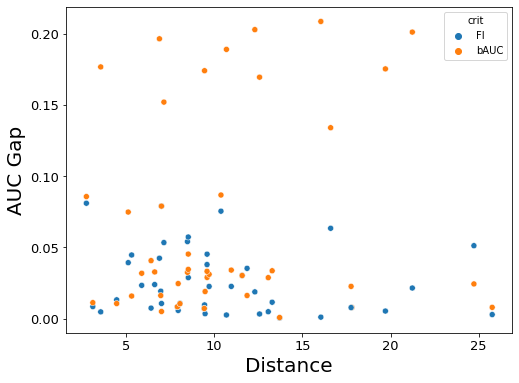

In [10]:
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(x='distince', y='auc_gap', hue='crit',data=df) 
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

ax.set_xlabel("Distance", fontsize=20)
ax.set_ylabel("AUC Gap", fontsize=20)
# ax.legend(..., fontsize=20)

plt.savefig('Diabetes_metric_AUC_Gap.pdf', dpi=300)
plt.show()